# California housing dataset regression with decision trees 

In this notebook, we'll use [decision trees](http://scikit-learn.org/stable/modules/tree.html) and [ensembles of trees](http://scikit-learn.org/stable/modules/ensemble.html) to estimate median house values on Californian housing districts using scikit-learn and [XGBoost](https://xgboost.readthedocs.io/en/latest/).

First, the needed imports. 

In [50]:
%matplotlib inline

import numpy as np
from sklearn import datasets, __version__
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Data

Then we load the California housing data. First time we need to download the data, which can take a while.

In [53]:
chd = datasets.fetch_california_housing()
chd

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------

We'll split the data into a training and a test set.

Let's also select a single attribute to start the analysis with, say *MedInc*.

In [52]:
test_size = 5000
single_attribute = 'MedInc'

X_train_all, X_test_all, y_train, y_test = train_test_split(
    chd.data, chd.target, test_size=test_size, shuffle=True)

attribute_index = chd.feature_names.index(single_attribute)
X_train_single = X_train_all[:, attribute_index].reshape(-1, 1)
X_test_single = X_test_all[:, attribute_index].reshape(-1, 1)
     
print()
print('California housing data: train:',len(X_train_all),'test:',len(X_test_all))
print()
print('X_train_all:', X_train_all.shape)
print('X_train_single:', X_train_single.shape)
print('y_train:', y_train.shape)
print()
print('X_test_all', X_test_all.shape)
print('X_test_single', X_test_single.shape)
print('y_test', y_test.shape)


California housing data: train: 15640 test: 5000

X_train_all: (15640, 8)
X_train_single: (15640, 1)
y_train: (15640,)

X_test_all (5000, 8)
X_test_single (5000, 1)
y_test (5000,)


The training data matrix `X_train_all` is a matrix of size (`n_train`, 8), and `X_train_single` contains only the first attribute (*MedInc* by default). The vector `y_train` contains the target value (median house value) for each housing district in the training set.

Let's start our analysis with the single attribute. Later, you can set `only_single_attribute = False` to use all eight attributes in the regression.

In [ ]:
only_single_attribute = True

if only_single_attribute:
    X_train = X_train_single
    X_test = X_test_single
else:
    X_train = X_train_all
    X_test = X_test_all

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('Y_train:', y_train.shape)

## Decision tree

Decision tree is a model that predicts the value of a target variable by learning simple *if-then-else* decision rules inferred from the data features.

### Learning

The parameter `max_depth` specifies the maximum depth of the tree.

In [ ]:
%%time

max_depth = 3
dt_reg = DecisionTreeRegressor(max_depth=max_depth)
dt_reg.fit(X_train, y_train)

We can visualize the results if we are using only a single attribute:

In [46]:
print(np.min(X_train))
print(np.max(X_train))
print(X_train)

0.4999
15.0001
[[2.3508]
 [4.0357]
 [4.4107]
 ...
 [5.9639]
 [1.9954]
 [2.725 ]]


In [49]:
reg_x = np.arange(np.min(X_train), np.max(X_train), 0.01).reshape(-1, 1)
print(reg_x)
print(dt_reg.predict(reg_x))
reg_x.dtype

[[ 0.4999]
 [ 0.5099]
 [ 0.5199]
 ...
 [14.9799]
 [14.9899]
 [14.9999]]
[1.21185416 1.21185416 1.21185416 ... 4.57184822 4.57184822 4.57184822]


dtype('float64')

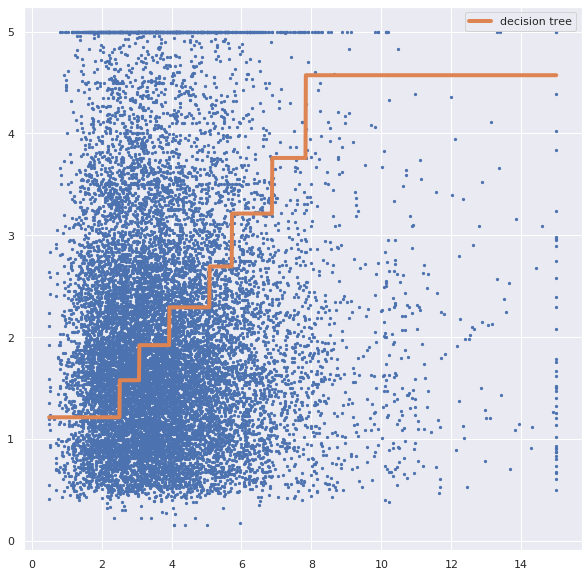

In [45]:
if X_train.shape[1] == 1:
    plt.figure(figsize=(10, 10))
    plt.scatter(X_train, y_train, s=5)
    reg_x = np.arange(np.min(X_train), np.max(X_train), 0.01).reshape(-1, 1)
    plt.plot(reg_x, dt_reg.predict(reg_x), lw=4, c=sns.color_palette()[1],
             label='decision tree')
    plt.legend(loc='best');

### Inference

We use *mean squared error* as the performance measure for our regression algorihm: 

In [ ]:
%%time

predictions = dt_reg.predict(X_test)
print("Mean squared error: %.3f"
      % mean_squared_error(y_test, predictions))

## Random forest

Random forest is an ensemble (or a group; hence the name *forest*) of decision trees, obtained by introducing randomness into the tree generation. The prediction of the random forest is obtained by *averaging* the predictions of the individual trees.

Random forest is a solid workhorse that almost always produces serviceable results without much tuning.

### Learning

Random forest classifiers are quick to train, quite robust to hyperparameter values, and often work relatively well.

In [47]:
%%time

n_estimators = 10
max_depth = 3
rf_reg = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth)
rf_reg.fit(X_train, y_train)

CPU times: user 42.7 ms, sys: 0 ns, total: 42.7 ms
Wall time: 41.9 ms


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

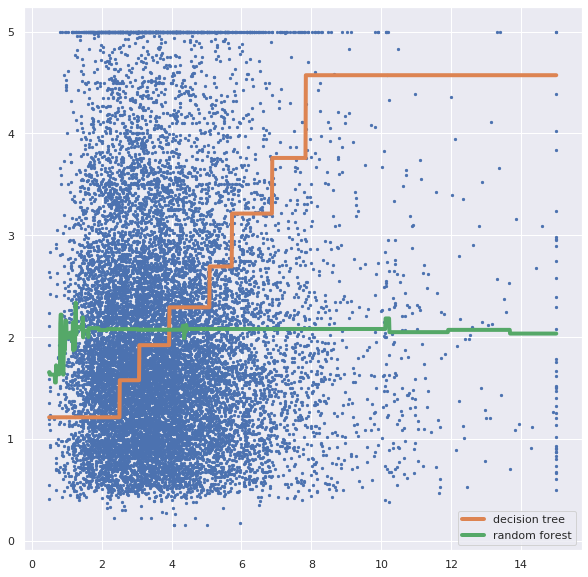

In [48]:
if X_train.shape[1] == 1:
    plt.figure(figsize=(10, 10))
    plt.scatter(X_train, y_train, s=5)
    reg_x = np.arange(np.min(X_train), np.max(X_train), 0.01).reshape(-1, 1)
    plt.plot(reg_x, dt_reg.predict(reg_x), lw=4, c=sns.color_palette()[1],
             label='decision tree')
    plt.plot(reg_x, rf_reg.predict(reg_x), lw=4, c=sns.color_palette()[2],
             label='random forest')
    plt.legend(loc='best');

### Inference

In [ ]:
%%time

predictions = rf_reg.predict(X_test)
print("Mean squared error: %.3f"
      % mean_squared_error(y_test, predictions))

## Gradient boosted trees (XGBoost)

Gradient boosted trees (or extreme gradient boosted trees) is another way of constructing ensembles of decision trees, using the *boosting* framework.  Let's use a popular separate package, [XGBoost](http://xgboost.readthedocs.io/en/latest/), to train gradient boosted trees for regression.  

XGBoost has been recently used to obtain record-breaking results on many machine learning competitions, but have quite a lot of hyperparameters that need to be carefully tuned to get the best performance.

### Learning

In [ ]:
%%time

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)

In [ ]:
if X_train.shape[1] == 1:
    plt.figure(figsize=(10, 10))
    plt.scatter(X_train, y_train, s=5)
    reg_x = np.arange(np.min(X_train), np.max(X_train), 0.01).reshape(-1, 1)
    plt.plot(reg_x, dt_reg.predict(reg_x), lw=4, c=sns.color_palette()[1],
             label='decision tree')
    plt.plot(reg_x, rf_reg.predict(reg_x), lw=4, c=sns.color_palette()[2],
             label='random forest')
    plt.plot(reg_x, xgb_reg.predict(reg_x), lw=4, c=sns.color_palette()[3],
             label='XGBoost')
    plt.legend(loc='best');

### Inference

In [ ]:
%%time

predictions = xgb_reg.predict(X_test)
print("Mean squared error: %.3f"
      % mean_squared_error(y_test, predictions))

## Model tuning

Study the documentation of the different decision tree models used in this notebook ([decision trees](http://scikit-learn.org/stable/modules/tree.html), [tree ensembles](http://scikit-learn.org/stable/modules/ensemble.html), [XGBoost](https://xgboost.readthedocs.io/en/latest/)), and experiment with different hyperparameter values.  

Report the lowest mean squared error you manage to obtain for each model type.  Also mark down the parameters you used, so others can try to reproduce your results. 